# Enron Emails Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

import gensim
from gensim import corpora
from gensim import models
from gensim.models import LdaModel
from gensim.models import LsiModel
import pyLDAvis
import warnings
warnings.filterwarnings("ignore")

In [2]:
stopwords = stopwords.words('english')
stopwords += ['would', 'http', 'com', 'cc', 'need', 'also', 'www', 'get', 'like', 'said', 'forwarded', 'mail', 'email']

In [3]:
pd.set_option('display.max_colwidth', -1)

In [4]:
df = pd.read_csv('data/enron_test.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      1000 non-null   object
 1   From      1000 non-null   object
 2   To        995 non-null    object
 3   Subject   698 non-null    object
 4   content   1000 non-null   object
 5   new_date  1000 non-null   object
dtypes: object(6)
memory usage: 47.0+ KB


In [6]:
df = df.drop_duplicates()

In [7]:
df.shape

(664, 6)

## Exploratory Data Analysis

### When do people send emails?

In [8]:
# pre-precess dates
df['year'] = df['Date'].apply(lambda x: x.split(' ')[3])
df['month'] = df['Date'].apply(lambda x: x.split(' ')[2])
df['day_of_week'] = df['Date'].apply(lambda x: x.split(',')[0])
df['hour'] = df['Date'].apply(lambda x: x.split(' ')[4][:2])

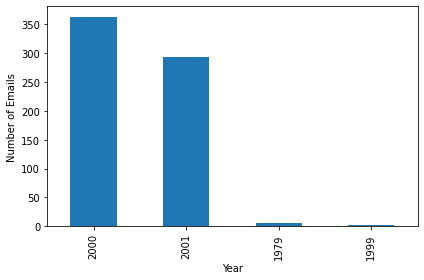

In [9]:
df['year'].value_counts().plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Number of Emails')
plt.tight_layout()
plt.savefig('img/year.png')

In [10]:
df = df[(df['year'] == '2000') | (df['year'] == '2001')]

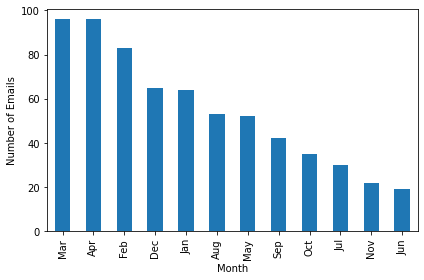

In [11]:
df['month'].value_counts().plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Number of Emails')
plt.tight_layout()
plt.savefig('img/month.png')

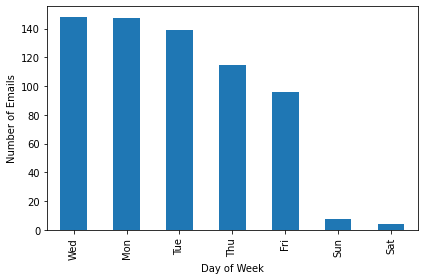

In [12]:
df['day_of_week'].value_counts().plot(kind='bar')
plt.xlabel('Day of Week')
plt.ylabel('Number of Emails')
plt.tight_layout()
plt.savefig('img/day_week.png')

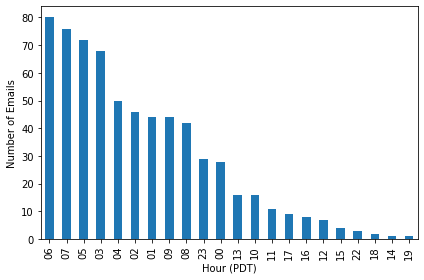

In [13]:
df['hour'].value_counts().plot(kind='bar')
plt.xlabel('Hour (PDT)')
plt.ylabel('Number of Emails')
plt.tight_layout()
plt.savefig('img/hour.png')

### Who sends the most emails?

In [14]:
df['sender'] = df['From'].apply(lambda x: x.split('\'')[1])

In [15]:
df['sender'].value_counts()[:5]

phillip.allen@enron.com      603
critical.notice@enron.com    5  
ina.rangel@enron.com         4  
ei_editor@ftenergy.com       2  
sarah.novosel@enron.com      2  
Name: sender, dtype: int64

In [16]:
df['recipient'] = df['To'].apply(lambda x: x.split('\'')[1] if type(x) == str else 'N/A')

In [17]:
# one sent to mulitple people
df['recipient'].value_counts()[:5]

jsmith@austintx.com           40
stagecoachmama@hotmail.com    40
ina.rangel@enron.com          37
pallen70@hotmail.com          27
keith.holst@enron.com         24
Name: recipient, dtype: int64

In [18]:
df_phillip_to_ina = df[(df['sender'] == 'phillip.allen@enron.com') & (df['recipient'] == 'ina.rangel@enron.com')]

In [19]:
for i in df_phillip_to_ina['content']:
    print('#' * 30)
    print(i)

##############################
---------------------- Forwarded by Phillip K Allen/HOU/ECT on 10/04/2000 
04:23 PM ---------------------------
   
	Enron North America Corp.
	
	From:  Airam Arteaga                           10/04/2000 12:23 PM
	

To: Phillip K Allen/HOU/ECT@ECT, Thomas A Martin/HOU/ECT@ECT, Scott 
Neal/HOU/ECT@ECT, John Arnold/HOU/ECT@ECT, Grant Masson/HOU/ECT@ECT, Ted 
Murphy/HOU/ECT@ECT, Vladimir Gorny/HOU/ECT@ECT, Frank Hayden/Corp/Enron@Enron
cc: Rita Hennessy/NA/Enron@Enron, Ina Rangel/HOU/ECT@ECT, Laura 
Harder/Corp/Enron@Enron, Kimberly Brown/HOU/ECT@ECT, Araceli 
Romero/NA/Enron@Enron, Kimberly Hillis/HOU/ECT@ect 
Subject: Var, Reporting and Resources Meeting

Please plan to attend the below  Meeting:


                                Topic:  Var, Reporting and Resources Meeting
        
  Date:  Wednesday, October 11th

  Time:  2:30 - 3:30 

  Location: EB30C1

  

 If you have any questions/conflicts, please feel free to call me.

Thanks,
Rain
x.31560








Seems like most of the emails sent by Phillip to Ina are forwarded messages.

In [20]:
df_phillip_to_phillip = df[(df['sender'] == 'phillip.allen@enron.com') & (df['recipient'] == 'pallen70@hotmail.com')]

In [21]:
for i in df_phillip_to_phillip['content']:
    print('#' * 30)
    print(i)

##############################
---------------------- Forwarded by Phillip K Allen/HOU/ECT on 10/03/2000 
04:30 PM ---------------------------


"George Richards" <cbpres@austin.rr.com> on 10/03/2000 06:35:56 AM
Please respond to <cbpres@austin.rr.com>
To: "Phillip Allen" <pallen@enron.com>
cc: "Larry Lewter" <retwell@mail.sanmarcos.net> 
Subject: Westgate


Westgate

Enclosed are demographics on the Westgate site from Investor's Alliance.
Investor's Alliance says that these demographics are similar to the package
on San Marcos that you received earlier.
If there are any other questions or information requirements, let me know.
Then, let me know your interest level in the Westgate project?

San Marcos
The property across the street from the Sagewood units in San Marcos is for
sale and approved for 134 units.  The land is selling for $2.50 per square
foot as it is one of only two remaining approved multifamily parcels in West
San Marcos, which now has a moratorium on development.

Sever

In [22]:
df_phillip_to_stage = df[(df['sender'] == 'phillip.allen@enron.com') & (df['recipient'] == 'stagecoachmama@hotmail.com')]

In [23]:
for i in df_phillip_to_stage['content']:
    print('#' * 30)
    print(i)

##############################
Lucy,

 Here are the rentrolls:



 Open them and save in the rentroll folder.  Follow these steps so you don't 
misplace these files.

 1.  Click on Save As
 2.  Click on the drop down triangle under Save in:
 3.  Click on the  (C): drive
 4.  Click on the appropriate folder
 5.  Click on Save:

Phillip
##############################
Lucy,

I want to have an accurate rent roll as soon as possible. I faxed you a copy 
of this file.  You can fill in on the computer or just write in the correct 
amounts and I will input.

##############################
Lucy,


You wrote fewer checks this month.  Spent more money on Materials and less on 
Labor.


   June  July  August

Total Materials  2929  4085  4801

Services  53  581  464

Labor   3187  3428  2770






Here are my questions on the August bank statement (attached):

1.  Check 1406  Walmart    Description and unit?

2.  Check 1410  Crumps     Detail description and unit?

3.  Check 1411  Lucy      What i

In [24]:
df_phillip_to_jsmith = df[(df['sender'] == 'phillip.allen@enron.com') & (df['recipient'] == 'keith.holst@enron.com')]

In [25]:
for i in df_phillip_to_jsmith['content']:
    print('#' * 30)
    print(i)

##############################
---------------------- Forwarded by Phillip K Allen/HOU/ECT on 10/09/2000 
02:16 PM ---------------------------


Richard Burchfield
10/06/2000 06:59 AM
To: Phillip K Allen/HOU/ECT@ECT
cc: Beth Perlman/HOU/ECT@ECT 
Subject: Consolidated positions: Issues & To Do list

Phillip,
 Below is the issues & to do list as we go forward with documenting the 
requirements for consolidated physical/financial positions and transport 
trade capture. What we need to focus on is the first bullet in Allan's list; 
the need for a single set of requirements. Although the meeting with Keith, 
on Wednesday,  was informative the solution of creating a infinitely dynamic 
consolidated position screen, will be extremely difficult and time 
consuming.  Throughout the meeting on Wednesday, Keith alluded to the 
inability to get consensus amongst the traders on the presentation of the 
consolidated position, so the solution was to make it so that a trader can 
arrange the position 

In [26]:
def preprocess_content(row):
    output = ''
    # remove punctuations
    lines = row.split('\n')
    for line in lines:
        if ':' not in line:
            for letter in line:
                output += re.sub(r'[\W\d^_]', ' ', letter)
    
    # remove stopwords
    output = word_tokenize(output)
    output = [word for word in output if word.lower() not in stopwords]
    sentence = ' '.join(output)
    
    # remove proper nouns
    tagged_sentence = nltk.tag.pos_tag(sentence.split())
    edited_sentence = [word for word,tag in tagged_sentence if tag != 'NNP' and tag != 'NNPS']
    clean_output = ' '.join(edited_sentence).lower()
    
    return clean_output

In [27]:
df['clean_content'] = df['content'].apply(preprocess_content)

In [28]:
df['clean_content'].head()

0    forecast                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
1    traveling business meeting takes fun trip prepare presentation suggest holding business plan meetings take trip without formal business meetings even try honest opinions whether trip even desired necessary far business meetings think productive try stimulate discussions across different groups working often presenter speaks others quiet waiting turn meetings might better held round table discussion format suggestion go golf rent ski boat jet ski flying somewhere takes much time
2    test successful way

## Topic Modeling with LDA

### Can we group emails into different topics?

In [29]:
tokens_list = [line.split() for line in df['clean_content'].tolist()]

In [30]:
#remove words that appear only once
from collections import defaultdict
frequency = defaultdict(int)

for tokens in tokens_list:
    for token in tokens:
        frequency[token] += 1
           
tokens_list = [[token for token in tokens if frequency[token]>1 and len(token) > 3 and token.isalpha()]
              for tokens in tokens_list]

In [31]:
{k: v for k, v in sorted(frequency.items(), key=lambda item: item[1], reverse=True)}

{'gas': 165,
 'power': 130,
 'time': 127,
 'project': 117,
 'new': 104,
 'cost': 102,
 'loan': 101,
 'market': 100,
 'one': 99,
 'call': 95,
 'prices': 94,
 'week': 94,
 'know': 91,
 'price': 86,
 'work': 85,
 'information': 79,
 'today': 78,
 'costs': 75,
 'want': 74,
 'use': 73,
 'think': 72,
 'year': 72,
 'please': 72,
 'meeting': 70,
 'plan': 69,
 'land': 67,
 'construction': 67,
 'going': 66,
 'go': 65,
 'day': 64,
 'last': 64,
 'enron': 62,
 'questions': 62,
 'see': 62,
 'us': 62,
 'deal': 61,
 'still': 61,
 'send': 60,
 'per': 60,
 'cash': 60,
 'make': 59,
 'forward': 58,
 'units': 58,
 'back': 58,
 'good': 57,
 'traders': 56,
 'help': 54,
 'lot': 54,
 'may': 54,
 'let': 53,
 'could': 53,
 'e': 53,
 'site': 51,
 'list': 51,
 'next': 50,
 'much': 49,
 'position': 49,
 'property': 49,
 'two': 49,
 'paid': 49,
 'utilities': 49,
 'rent': 47,
 'trading': 47,
 'based': 47,
 'loans': 47,
 'find': 47,
 'date': 47,
 'file': 47,
 'since': 47,
 'total': 46,
 'office': 46,
 'access': 46,
 '

In [32]:
tokens_list[:10]

[['forecast'],
 ['traveling',
  'business',
  'meeting',
  'takes',
  'trip',
  'prepare',
  'presentation',
  'suggest',
  'holding',
  'business',
  'plan',
  'meetings',
  'take',
  'trip',
  'without',
  'formal',
  'business',
  'meetings',
  'even',
  'honest',
  'opinions',
  'whether',
  'trip',
  'even',
  'desired',
  'necessary',
  'business',
  'meetings',
  'think',
  'productive',
  'stimulate',
  'discussions',
  'across',
  'different',
  'groups',
  'working',
  'often',
  'presenter',
  'speaks',
  'others',
  'quiet',
  'waiting',
  'turn',
  'meetings',
  'might',
  'better',
  'held',
  'round',
  'table',
  'discussion',
  'format',
  'suggestion',
  'golf',
  'rent',
  'boat',
  'flying',
  'somewhere',
  'takes',
  'much',
  'time'],
 ['test', 'successful'],
 ['send',
  'schedule',
  'salary',
  'level',
  'everyone',
  'scheduling',
  'group',
  'plus',
  'thoughts',
  'changes',
  'made',
  'example'],
 [],
 ['either', 'next'],
 ['pallen', 'enron', 'mike', 'gr

In [33]:
# generate token dictionary class
dictionary = corpora.Dictionary(tokens_list) 
print(dictionary)

Dictionary(2856 unique tokens: ['forecast', 'across', 'better', 'boat', 'business']...)


In [34]:
# generate a unique token list 
sort_token = sorted(dictionary.items(),key=lambda k:k[0], reverse = False)
unique_token = [token for (ID,token) in sort_token]

In [35]:
# build a corpus
corpus = [dictionary.doc2bow(tokens) for tokens in tokens_list]  
# (0, 1) == first word in unique token list appeared 1 time

In [36]:
df['corpus'] = corpus

In [78]:
# fit lda model
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=4, passes=25) 

In [81]:
topic_list = lda.print_topics(num_topics=4, num_words=10)

In [82]:
topic_list

[(0,
  '0.014*"loan" + 0.014*"cost" + 0.011*"land" + 0.011*"loans" + 0.010*"construction" + 0.010*"costs" + 0.008*"value" + 0.007*"equity" + 0.007*"basis" + 0.006*"fees"'),
 (1,
  '0.014*"power" + 0.013*"prices" + 0.008*"price" + 0.007*"week" + 0.007*"market" + 0.006*"time" + 0.006*"today" + 0.005*"call" + 0.005*"traders" + 0.005*"trades"'),
 (2,
  '0.011*"project" + 0.005*"market" + 0.005*"time" + 0.005*"send" + 0.005*"loan" + 0.005*"know" + 0.004*"cash" + 0.004*"work" + 0.004*"back" + 0.004*"property"'),
 (3,
  '0.010*"information" + 0.008*"meeting" + 0.008*"position" + 0.007*"call" + 0.007*"desk" + 0.006*"please" + 0.006*"access" + 0.005*"date" + 0.005*"help" + 0.005*"book"')]

In [83]:
topic_words = []
for topic in topic_list:
    words = []
    line = topic[1].split('\"')
    for i, j in enumerate(line):
        if i % 2 != 0:
            words.append(j)
            print(j)
    print('---')
    topic_words.append(words)

loan
cost
land
loans
construction
costs
value
equity
basis
fees
---
power
prices
price
week
market
time
today
call
traders
trades
---
project
market
time
send
loan
know
cash
work
back
property
---
information
meeting
position
call
desk
please
access
date
help
book
---


In [84]:
def classify(row):
    topic = max(lda[row],key=lambda item:item[1])[0] 
    return topic

In [85]:
df['topic'] = df['corpus'].apply(classify)

In [86]:
df['month_year'] = df['month'] + ' ' + df['year']
df['month_year'] = pd.to_datetime(df['month_year'])

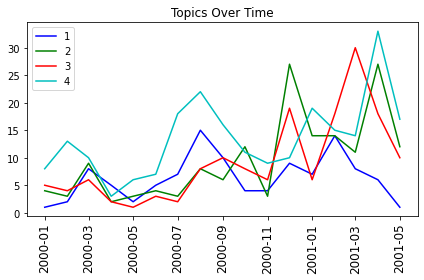

In [89]:
df_topic = df.groupby(['month_year', 'topic']).count().reset_index()
color = ['b', 'g', 'r', 'c']
for i in range(1, 5):
    plt.plot('month_year', 'corpus', data=df_topic[df_topic['topic'] == i - 1], color=color[i - 1])
plt.title('Topics Over Time')
plt.xticks(fontsize=12, rotation=90)
plt.legend(range(1, 5))
plt.tight_layout()
plt.savefig('img/topic.png')
plt.show()